<a href="https://colab.research.google.com/github/fatemehabedin2/AIG/blob/main/Project3_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I am using text8 dataset from kaggle to create a text generator using LSTM model.

In [ ]:
import kagglehub
import os

path = kagglehub.dataset_download("gupta24789/text8-word-embedding")

# Check what files are downloaded
print("Dataset downloaded to:", path)
print("Files in dataset:")
print(os.listdir(path))


Dataset downloaded to: /kaggle/input/text8-word-embedding
Files in dataset:
['text8']


In [ ]:
import torch

print("PyTorch version:", torch.__version__)
if torch.cuda.is_available():
    print("GPU is available for PyTorch!")
else:
    print("No GPU found for PyTorch.")

PyTorch version: 2.6.0+cu124
GPU is available for PyTorch!


Let’s:

Read the file

Display a sample of words

Confirm the vocabulary size

In [ ]:
with open(os.path.join(path, "text8"), "r") as file:
    text = file.read()

print("Length of raw text:", len(text))
print("First 500 characters:", text[:500])

Length of raw text: 713069767
First 500 characters:  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso


Even though text8 is already lowercased, alphabetic-only, space-separated, I'll still use the standard practice for pre-processing step.

In [ ]:
import re

def preprocess_text(text):
    text = text.lower()

    # Removes anything that’s not a-z or whitespace. replace anything other than a-z or whitespace with "". ^ inside [] means anything other than
    text = re.sub(r"[^a-z\s]", "", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text


clean_text = preprocess_text(text)
len(clean_text)

713069766

In [ ]:
words = clean_text.split()

print("First 20 words:", words[:20])
print("Total number of words:", len(words))

First 20 words: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']
Total number of words: 124301826


# Word-Level Modeling
I am going to use Word-Level Modeling, because it Learns semantic meaning better, so it would be more natural for real language modeling compared to Character-Level Modeling.

# Vocabulary and Encoding
Build the word2idx and idx2word dictionaries.

word2idx: Word ➝ Integer is used during: Preprocessing / training and Model input creation.

idx2word: Integer ➝ Word is used during: Text generation (predictions) and Evaluation / debugging


# Reducing the number of words to prevent exceeding RAM

Due to session crashes multiple times, I am reducing the vocab_size to 50k (using most common words), also reduce the encoded_text to 1M words for training.
I also tried to stream the data instead of loading it on memory all at once.

In [ ]:
from collections import Counter

top_k = 50000  # reduce to top 50k most frequent words
word_counts = Counter(words)
top_k_words = set(word for word, _ in word_counts.most_common(top_k))

# Build index only for top_k words
word2idx = {word: idx for idx, word in enumerate(sorted(top_k_words))}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(word2idx)

encoded_text = [word2idx[word] for word in words if word in word2idx]

In [ ]:
# Use only 1M tokens due to memory limit
encoded_text = encoded_text[:1000000]

In [ ]:
len(encoded_text)

1000000

# Streaming Dataset + DataLoader

After running loading data code my colab session crashed with the message: "Your session crashed after using all available RAM", because we're generating millions of sequences, and storing each as a list inside inputs.

Now instead of preloading all sequences, I try to create them on-the-fly in the Dataset class. This way we don't store all sequences in memory.

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Split: 90% training, 10% validation (not random). train on the beginning of the dataset and test (validate) on the ending part
split_idx = int(0.9 * len(encoded_text))
train_data = encoded_text[:split_idx]
val_data   = encoded_text[split_idx:]


class Text8StreamingDataset(Dataset):
    def __init__(self, encoded_text, sequence_length):
        self.data = encoded_text
        self.seq_len = sequence_length

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx + self.seq_len], dtype=torch.long)
        y = torch.tensor(self.data[idx + self.seq_len], dtype=torch.long)
        return x, y


sequence_length = 20
batch_size = 32     # DataLoader will Select 32 random indices. For each of those 32 indices, It calls dataset’s __getitem__(idx): Now we have 32 sequences of 20 words (x_batch: [32, 20], y_batch:[32])

# Create train and validation DataLoaders
train_dataset = Text8StreamingDataset(train_data, sequence_length)
val_dataset   = Text8StreamingDataset(val_data, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)     # Colab often crashes when num_workers > 0 in DataLoader, so I keep it as 0.


# LSTM Language Model

We'll build a basic LSTM that:

Takes a sequence of word indices [32, 20]

Embeds them to vectors (like word2vec)

Feeds them through LSTM layers

Outputs a logit for each word in the vocabulary

The output size is vocab_size because our model is doing classification over the entire vocabulary. it predicts the next word by selecting from all possible words.

In [ ]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2):      # input_size=embedding_dim, hidden_size=hidden_dim, output_size=vocab_size
        super(LSTMLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)       # Each word index maps to a dense vectors (embeddings). Every word ID gets a trainable vector of fixed size, like weights, trained along with our model, change every epoch, optimized via backpropagation,and learn to capture semantic similarity.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)    # batch_first=True >> input shape = [batch_size, seq_len, embedding_dim] >> more intuitive and Compatible with DataLoader batches
        self.fc = nn.Linear(hidden_dim, vocab_size)         # hidden_dim: The size of the hidden state vector for each LSTM unit at every time step

    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)       # [batch_size, seq_len, embedding_dim]
        lstm_out, _ = self.lstm(embedded)  # lstm_out: [batch_size, seq_len, hidden_dim]
        final_hidden = lstm_out[:, -1, :]  # Take output from last timestep → [batch_size, hidden_dim]
        logits = self.fc(final_hidden)     # [batch_size, vocab_size]
        return logits

started with embedding_dim = 128, hidden_dim = 256 but colab session crashed due to memory limit because the embedding matrix becomes too large, so I reduced to embedding_dim = 64 and hidden_dim = 128

In [ ]:
embedding_dim = 64
hidden_dim = 128
#vocab_size = len(word2idx)
#vocab_size = 50000  #  # makes the model less expressive but we do not have other choice

model = LSTMLanguageModel(vocab_size, embedding_dim, hidden_dim)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the LSTM Language Model

we’ll create the full training loop that:

Loads batches of sequences

Feeds them to the model

Computes loss using CrossEntropyLoss

Backpropagates

Updates weights using Adam

In [ ]:
import math

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 5
train_losses = []
val_losses = []

model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        logits = model(x_batch)

        #assert y_batch.max() < logits.shape[1], " Target word index out of bounds!"
        #assert y_batch.min() >= 0, " Target word index is negative!"
        #print("Logits shape:", logits.shape)
        #print("y_batch shape:", y_batch.shape)
        #print("Max target index:", y_batch.max().item())
        #print("Min target index:", y_batch.min().item())
        #print("Vocab size (from model):", model.fc.out_features)  # output layer size

        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_perplexity = math.exp(avg_train_loss)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            logits = model(x_val)
            loss = criterion(logits, y_val)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_perplexity = math.exp(avg_val_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Perplexity: {train_perplexity:.2f} | Val Perplexity: {val_perplexity:.2f}")

Epoch 1/5 | Train Loss: 5.4703 | Val Loss: 6.4779 | Train Perplexity: 237.53 | Val Perplexity: 650.60
Epoch 2/5 | Train Loss: 5.3933 | Val Loss: 6.4921 | Train Perplexity: 219.92 | Val Perplexity: 659.93
Epoch 3/5 | Train Loss: 5.3253 | Val Loss: 6.5794 | Train Perplexity: 205.48 | Val Perplexity: 720.09
Epoch 4/5 | Train Loss: 5.2588 | Val Loss: 6.6233 | Train Perplexity: 192.25 | Val Perplexity: 752.39
Epoch 5/5 | Train Loss: 5.1915 | Val Loss: 6.6590 | Train Perplexity: 179.74 | Val Perplexity: 779.79


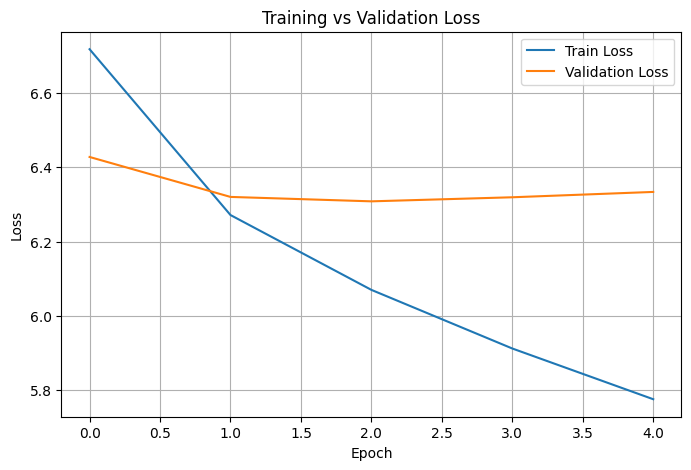

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Try Dropout Regularization

In [ ]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2):
        super(LSTMLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)  # adding dropout
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        final_hidden = lstm_out[:, -1, :]
        logits = self.fc(final_hidden)
        return logits

In [ ]:
embedding_dim = 64
hidden_dim = 128
#vocab_size = len(word2idx)
#vocab_size = 50000

model = LSTMLanguageModel(vocab_size, embedding_dim, hidden_dim)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Try defining the scheduler for Learning Rate
Example: Reduce LR by half every 2 epochsto Reduces the learning rate

In [ ]:
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=2, gamma=0.5)


In [ ]:
import math

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 5
train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []

model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_perplexity = math.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_perplexities.append(train_perplexity)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            logits = model(x_val)
            loss = criterion(logits, y_val)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_perplexity = math.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_perplexities.append(val_perplexity)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Perplexity: {train_perplexity:.2f} | Val Perplexity: {val_perplexity:.2f}")
    scheduler.step()

Epoch 1/5 | Train Loss: 6.2636 | Val Loss: 6.2907 | Train Perplexity: 525.09 | Val Perplexity: 539.56
Epoch 2/5 | Train Loss: 6.0744 | Val Loss: 6.3134 | Train Perplexity: 434.59 | Val Perplexity: 551.92
Epoch 3/5 | Train Loss: 5.8701 | Val Loss: 6.2858 | Train Perplexity: 354.28 | Val Perplexity: 536.91
Epoch 4/5 | Train Loss: 5.7904 | Val Loss: 6.3022 | Train Perplexity: 327.15 | Val Perplexity: 545.80
Epoch 5/5 | Train Loss: 5.6695 | Val Loss: 6.3073 | Train Perplexity: 289.90 | Val Perplexity: 548.58


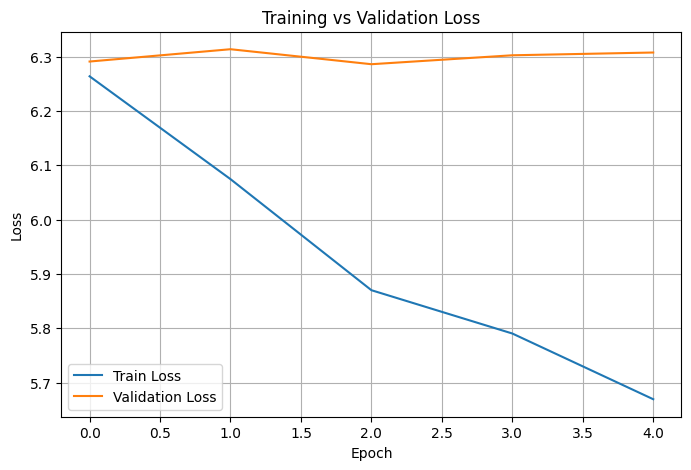

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

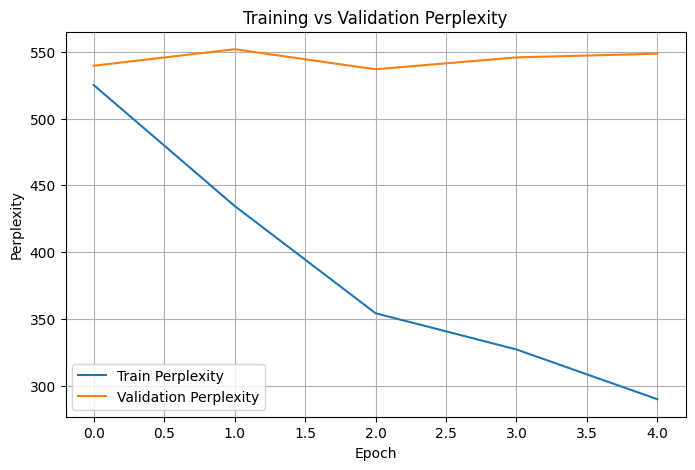

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_perplexities, label='Train Perplexity')
plt.plot(val_perplexities, label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training vs Validation Perplexity')
plt.legend()
plt.grid(True)
plt.show()

# Reduce Model Complexity

As the previous techniques (scheduler and dropout) did not help for overfitting issue, I am trying to reduce the model dimensions.

In [ ]:
from torch.optim.lr_scheduler import StepLR

embedding_dim = 64
hidden_dim = 64

model = LSTMLanguageModel(vocab_size, embedding_dim, hidden_dim)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# scheduler = StepLR(optimizer, step_size=2, gamma=0.5)


In [ ]:
import math

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 5
train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []

model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_perplexity = math.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_perplexities.append(train_perplexity)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            logits = model(x_val)
            loss = criterion(logits, y_val)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_perplexity = math.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_perplexities.append(val_perplexity)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Perplexity: {train_perplexity:.2f} | Val Perplexity: {val_perplexity:.2f}")
    scheduler.step()

Epoch 1/5 | Train Loss: 6.7643 | Val Loss: 6.4005 | Train Perplexity: 866.36 | Val Perplexity: 602.15
Epoch 2/5 | Train Loss: 6.3556 | Val Loss: 6.3195 | Train Perplexity: 575.70 | Val Perplexity: 555.32
Epoch 3/5 | Train Loss: 6.2192 | Val Loss: 6.3398 | Train Perplexity: 502.30 | Val Perplexity: 566.66
Epoch 4/5 | Train Loss: 6.1191 | Val Loss: 6.3455 | Train Perplexity: 454.45 | Val Perplexity: 569.93
Epoch 5/5 | Train Loss: 6.0433 | Val Loss: 6.3541 | Train Perplexity: 421.28 | Val Perplexity: 574.87


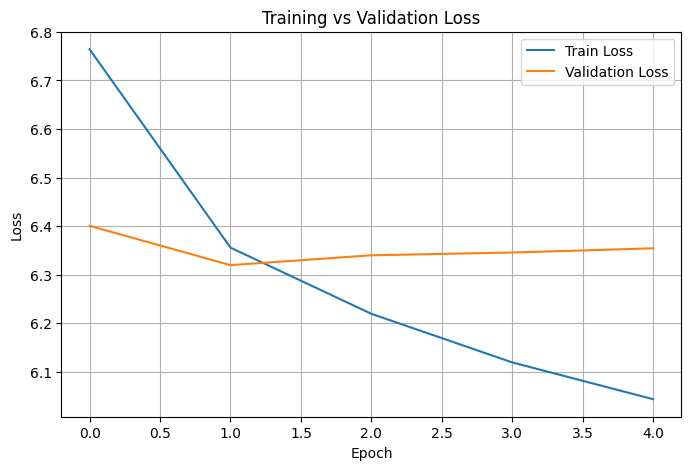

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

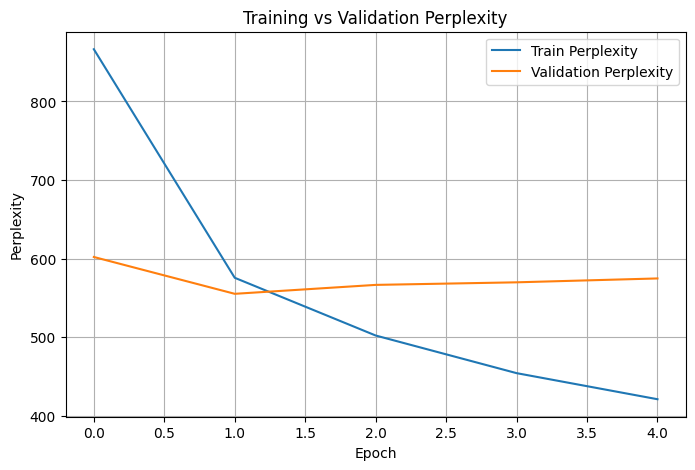

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_perplexities, label='Train Perplexity')
plt.plot(val_perplexities, label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training vs Validation Perplexity')
plt.legend()
plt.grid(True)
plt.show()

Model is still overfitting and will not work well on unseen data, but I am going to try generating some text using this model just for later comparison.

In [ ]:
def generate_text(model, start_text, word2idx, idx2word, num_words=20, temperature=1.0):  # temperature: controls randomness of output (higher = more random)
    model.eval()         # Turns off dropout and gradient tracking, ensuring model will produce the same output every time we run the same input through it
    words = start_text.strip().split()
    input_seq = torch.tensor([word2idx.get(w, 0) for w in words[-sequence_length:]], dtype=torch.long).unsqueeze(0).to(device)  # Converts the last sequence_length words into their indices (word2idx.get(w, 0) uses 0 for unknown words).
                                                                                                                                # PyTorch RNNs like nn.LSTM expect inputs in shape [batch size, sequence_length]. unsqueeze(0) adds 1 as batch size
    generated = words.copy() # stores the final list of words
    hidden = None

    for _ in range(num_words): # Loop to generate one word at a time.
        with torch.no_grad():
            output, hidden = model.lstm(model.embedding(input_seq), hidden) # Applies the embedding layer to convert input word indices into vectors. Applies the embedding layer to convert word indices into vectors. Gets the LSTM output and new hidden state.
            logits = model.fc(output[:, -1, :]) / temperature  # Takes the last output from LSTM sequence, Passes it through the final linear layer to get logits of words. Low temperature (<1) = more conservative (high-confidence predictions). High temperature (>1) = more diverse and random output
            probs = torch.softmax(logits, dim=-1)     # Applies softmax to get probabilities over vocabulary.
            next_word_idx = torch.multinomial(probs, num_samples=1).item()        # torch.multinomial(probs, num_samples=1): samples from a probability distribution. most of the time, it returns the highest probability, but But sometimes return other the other indexes, due to randomness. It’s not greedy, it allows variation, which is important for generating diverse, natural-sounding text.

            next_word = idx2word.get(next_word_idx, "<unk>")   # If that index is not found, return the placeholder string "<unk>". standard token used in NLP to represent Words not in the vocabulary (out-of-vocabulary or OOV) or Corrupt/missing indices during decoding
            generated.append(next_word)

            input_seq = torch.cat([input_seq[:, 1:], torch.tensor([[next_word_idx]], device=device)], dim=1) # Update input for the next time step. Update input for the next time step. Appending next_word_idx as the new last token
                                                                                                             # torch.cat(): Concatenates tensors along a specific dimension.

    return ' '.join(generated)  # Converts list of words back to a string and returns it.


print(generate_text(model, "the king of", word2idx, idx2word))


the king of a young slam remaining special new actress in one nine eight nine four has a major major journal in one


In [ ]:
print(generate_text(model, "what we love", word2idx, idx2word))

what we love epistles the principle of the his abandonment in the structure of alchemy in twelve free we turn the brain credited


In [ ]:
print(generate_text(model, "in th night the sky is", word2idx, idx2word))

in th night the sky is from honor as they is changed with human master victories after the rosetta was born and son it was ultra


# adding early stopping to prevent overfitting

In [ ]:
import math

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 20
patience = 2  # Stop if val loss doesn't improve after N epochs
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []

best_model_state = None  # for saving best model

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_perplexity = math.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_perplexities.append(train_perplexity)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            logits = model(x_val)
            loss = criterion(logits, y_val)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_perplexity = math.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_perplexities.append(val_perplexity)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train PPL: {train_perplexity:.2f} | Val PPL: {val_perplexity:.2f}")

    # Step scheduler
    scheduler.step()

    # Early Stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save best model
        torch.save(best_model_state, 'best_model.pth')  # Optional
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break


Epoch 1/20 | Train Loss: 5.9852 | Val Loss: 6.3541 | Train PPL: 397.50 | Val PPL: 574.86
Epoch 2/20 | Train Loss: 5.9350 | Val Loss: 6.3775 | Train PPL: 378.05 | Val PPL: 588.46
No improvement for 1 epoch(s)
Epoch 3/20 | Train Loss: 5.8884 | Val Loss: 6.3710 | Train PPL: 360.84 | Val PPL: 584.65
No improvement for 2 epoch(s)
Early stopping triggered.


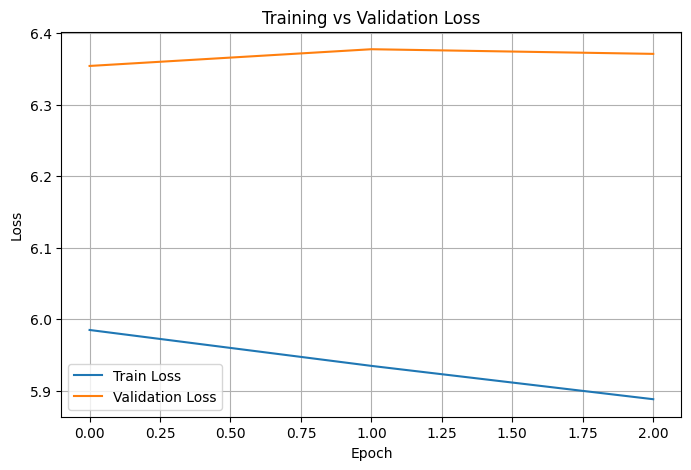

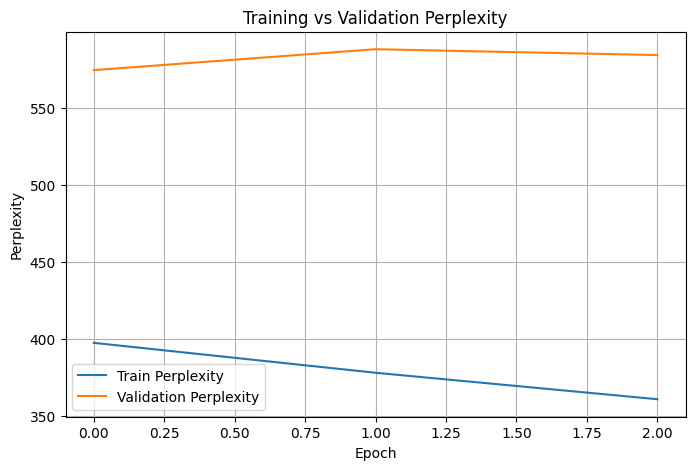

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_perplexities, label='Train Perplexity')
plt.plot(val_perplexities, label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training vs Validation Perplexity')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def generate_text(model, start_text, word2idx, idx2word, num_words=20, temperature=1.0):
    model.eval()
    words = start_text.strip().split()
    input_seq = torch.tensor([word2idx.get(w, 0) for w in words[-sequence_length:]], dtype=torch.long).unsqueeze(0).to(device)

    generated = words.copy()
    hidden = None

    for _ in range(num_words):
        with torch.no_grad():
            output, hidden = model.lstm(model.embedding(input_seq), hidden)
            logits = model.fc(output[:, -1, :]) / temperature
            probs = torch.softmax(logits, dim=-1)
            next_word_idx = torch.multinomial(probs, num_samples=1).item()

            next_word = idx2word.get(next_word_idx, "<unk>")
            generated.append(next_word)

            input_seq = torch.cat([input_seq[:, 1:], torch.tensor([[next_word_idx]], device=device)], dim=1)

    return ' '.join(generated)


print(generate_text(model, "the king of", word2idx, idx2word))


the king of the terror to thomas the uppercase holy controversial well known as the fuel could be one in position such as


In [ ]:
print(generate_text(model, "what we love", word2idx, idx2word))

what we love the assumption that he took that prince is grab where he never explained whatever if many did hector a effort


In [ ]:
print(generate_text(model, "in the night the sky is", word2idx, idx2word))

in th night the sky is derived from by let bible pushed of a trial more than three charge incorporated in the antiquity letter players with


# Reducing model complexity to prevent overfitting while increasing the training data to 10M

I reduced the number of lstm layers and learning rates and the embedding_dim = 64
hidden_dim = 64, while increasing the data to 10M words.

In [ ]:
# Use only 10M tokens due to memory limit
encoded_text = encoded_text[:10000000]

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Split: 90% training, 10% validation (not random). train on the beginning of the dataset and test (validate) on the ending part
split_idx = int(0.9 * len(encoded_text))
train_data = encoded_text[:split_idx]
val_data   = encoded_text[split_idx:]


class Text8StreamingDataset(Dataset):
    def __init__(self, encoded_text, sequence_length):
        self.data = encoded_text
        self.seq_len = sequence_length

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx + self.seq_len], dtype=torch.long)
        y = torch.tensor(self.data[idx + self.seq_len], dtype=torch.long)
        return x, y


sequence_length = 20
batch_size = 32

# Create train and validation DataLoaders
train_dataset = Text8StreamingDataset(train_data, sequence_length)
val_dataset   = Text8StreamingDataset(val_data, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)     # Colab often crashes when num_workers > 0 in DataLoader.

In [ ]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):      # num_layers=1 >> reducing model complexity to reduce overfitting
        super(LSTMLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        final_hidden = lstm_out[:, -1, :]
        logits = self.fc(final_hidden)
        return logits

In [ ]:
from torch.optim.lr_scheduler import StepLR

embedding_dim = 64
hidden_dim = 64

model = LSTMLanguageModel(vocab_size, embedding_dim, hidden_dim)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)     # reducing lr to reduce overfitting

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [ ]:
import math

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 5
train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []

model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_perplexity = math.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_perplexities.append(train_perplexity)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            logits = model(x_val)
            loss = criterion(logits, y_val)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_perplexity = math.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_perplexities.append(val_perplexity)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train Perplexity: {train_perplexity:.2f} | Val Perplexity: {val_perplexity:.2f}")
    #scheduler.step()

Epoch 1/5 | Train Loss: 6.8906 | Val Loss: 6.8786 | Train Perplexity: 982.96 | Val Perplexity: 971.25
Epoch 2/5 | Train Loss: 6.7587 | Val Loss: 6.7937 | Train Perplexity: 861.55 | Val Perplexity: 892.20
Epoch 3/5 | Train Loss: 6.6864 | Val Loss: 6.7434 | Train Perplexity: 801.40 | Val Perplexity: 848.42
Epoch 4/5 | Train Loss: 6.6363 | Val Loss: 6.7066 | Train Perplexity: 762.25 | Val Perplexity: 817.79
Epoch 5/5 | Train Loss: 6.5975 | Val Loss: 6.6791 | Train Perplexity: 733.25 | Val Perplexity: 795.63


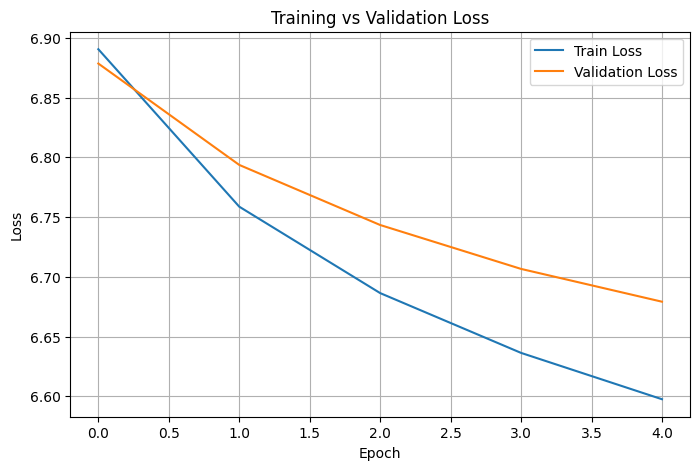

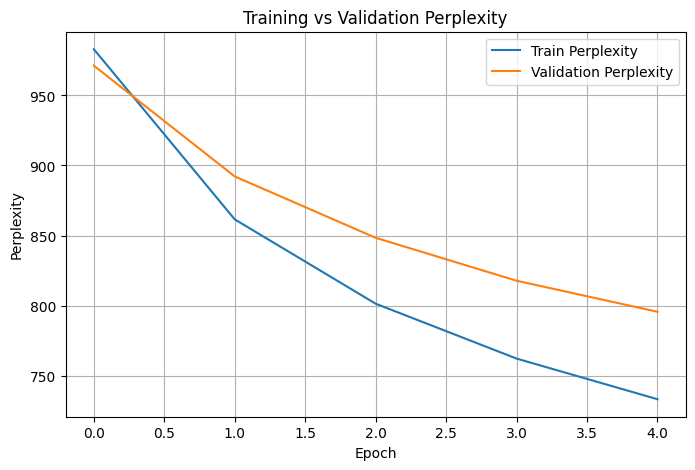

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_perplexities, label='Train Perplexity')
plt.plot(val_perplexities, label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training vs Validation Perplexity')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def generate_text(model, start_text, word2idx, idx2word, num_words=20, temperature=1.0):
    model.eval()
    words = start_text.strip().split()
    input_seq = torch.tensor([word2idx.get(w, 0) for w in words[-sequence_length:]], dtype=torch.long).unsqueeze(0).to(device)

    generated = words.copy()
    hidden = None

    for _ in range(num_words):
        with torch.no_grad():
            output, hidden = model.lstm(model.embedding(input_seq), hidden)
            logits = model.fc(output[:, -1, :]) / temperature
            probs = torch.softmax(logits, dim=-1)
            next_word_idx = torch.multinomial(probs, num_samples=1).item()

            next_word = idx2word.get(next_word_idx, "<unk>")
            generated.append(next_word)

            input_seq = torch.cat([input_seq[:, 1:], torch.tensor([[next_word_idx]], device=device)], dim=1)

    return ' '.join(generated)


print(generate_text(model, "the king of", word2idx, idx2word))
print(generate_text(model, "what we love", word2idx, idx2word))
print(generate_text(model, "in th night the sky is", word2idx, idx2word))

the king of canada s guatemala college was a widely compositions until the mix and defensive motorcycles gamma instead of the first symbols
what we love sacrament watch s festival reserved judaism deaths took some or from religious sahara tradition binomial franc belarus similarly have used
in th night the sky is tens without abuse which companies some remember and its integers the afghan organization carved fame to the sanctuary of behind


In [ ]:
print(generate_text(model, "what we love is ", word2idx, idx2word))
print(generate_text(model, "at th night the sky is", word2idx, idx2word))

what we love is on newer depth fresh by ideology returned a way of radical capabilities the libyan remembered avoid minutes on a crucial
at th night the sky is approaches these who can be composers that there is often crop or that still possible totally finger for the late


# Increased the num_epochs with early stopping

As our model is now learning without any sign of overfitting after 5 epochs I will increase the number of epochs to 20 with early stopping sfter 2 patience

In [ ]:
import math

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 20
patience = 2  # Stop if val loss doesn't improve after 2 epochs
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []

best_model_state = None  # for saving best model

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_perplexity = math.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_perplexities.append(train_perplexity)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            logits = model(x_val)
            loss = criterion(logits, y_val)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_perplexity = math.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_perplexities.append(val_perplexity)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train PPL: {train_perplexity:.2f} | Val PPL: {val_perplexity:.2f}")

    # Step scheduler
    # scheduler.step()

    # Early Stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save best model
        torch.save(best_model_state, 'best_model.pth')  # Optional
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break


Epoch 1/20 | Train Loss: 7.2334 | Val Loss: 7.0469 | Train PPL: 1384.89 | Val PPL: 1149.30
Epoch 2/20 | Train Loss: 6.8952 | Val Loss: 6.8849 | Train PPL: 987.52 | Val PPL: 977.41
Epoch 3/20 | Train Loss: 6.7652 | Val Loss: 6.7978 | Train PPL: 867.14 | Val PPL: 895.86
Epoch 4/20 | Train Loss: 6.6905 | Val Loss: 6.7470 | Train PPL: 804.72 | Val PPL: 851.46
Epoch 5/20 | Train Loss: 6.6366 | Val Loss: 6.7032 | Train PPL: 762.47 | Val PPL: 815.01
Epoch 6/20 | Train Loss: 6.5970 | Val Loss: 6.6777 | Train PPL: 732.90 | Val PPL: 794.50
Epoch 7/20 | Train Loss: 6.5672 | Val Loss: 6.6534 | Train PPL: 711.37 | Val PPL: 775.42
Epoch 8/20 | Train Loss: 6.5401 | Val Loss: 6.6366 | Train PPL: 692.35 | Val PPL: 762.46
Epoch 9/20 | Train Loss: 6.5209 | Val Loss: 6.6247 | Train PPL: 679.16 | Val PPL: 753.46
Epoch 10/20 | Train Loss: 6.5062 | Val Loss: 6.6167 | Train PPL: 669.31 | Val PPL: 747.46
Epoch 11/20 | Train Loss: 6.4939 | Val Loss: 6.6072 | Train PPL: 661.12 | Val PPL: 740.42
Epoch 12/20 | Tra

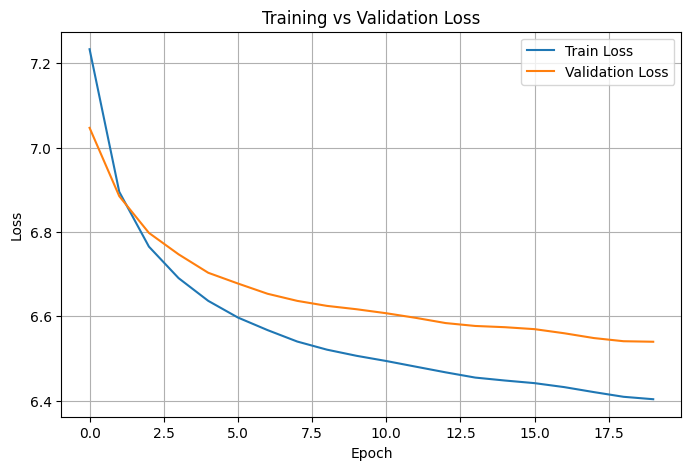

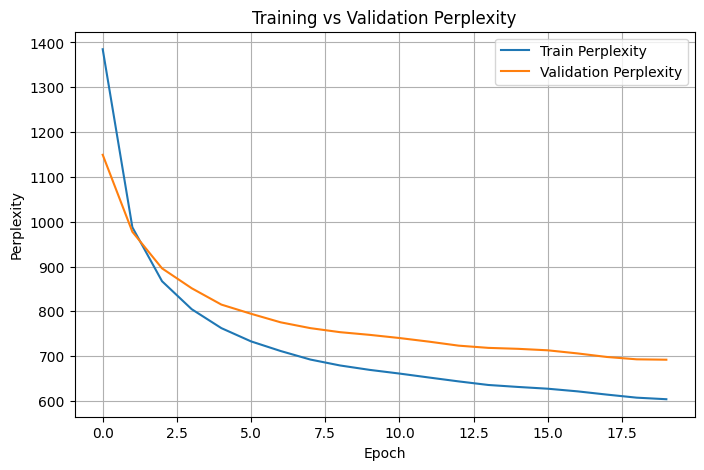

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_perplexities, label='Train Perplexity')
plt.plot(val_perplexities, label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training vs Validation Perplexity')
plt.legend()
plt.grid(True)
plt.show()

However in our task, loss an perplexity are better metrics, i am going to try accuracy as well.

In [ ]:
import math

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            logits = model(x_batch)  # Shape: [batch_size, vocab_size]
            loss = criterion(logits, y_batch)
            total_loss += loss.item() * y_batch.size(0)  # weighted sum of losses

            # Accuracy
            predicted = torch.argmax(logits, dim=1)
            correct = (predicted == y_batch).sum().item()
            total_correct += correct
            total_tokens += y_batch.size(0)

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    accuracy = total_correct / total_tokens

    return avg_loss, perplexity, accuracy


val_loss, val_ppl, val_acc = evaluate_model(model, val_loader, criterion, device)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Perplexity: {val_ppl:.2f}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


Validation Loss: 6.5396
Validation Perplexity: 691.99
Validation Accuracy: 15.94%


I am also adding temperature to add some degree of randomness to make the generated text more natural (temperature =1.0  >> 3.0)

In [ ]:
def generate_text(model, start_text, word2idx, idx2word, num_words=10,temperature =3.0):
    model.eval()
    words = start_text.strip().split()
    input_seq = torch.tensor([word2idx.get(w, 0) for w in words[-sequence_length:]], dtype=torch.long).unsqueeze(0).to(device)

    generated = words.copy()
    hidden = None

    for _ in range(num_words):
        with torch.no_grad():
            output, hidden = model.lstm(model.embedding(input_seq), hidden)
            logits = model.fc(output[:, -1, :]) / temperature
            probs = torch.softmax(logits, dim=-1)
            next_word_idx = torch.multinomial(probs, num_samples=1).item()

            next_word = idx2word.get(next_word_idx, "<unk>")
            generated.append(next_word)

            input_seq = torch.cat([input_seq[:, 1:], torch.tensor([[next_word_idx]], device=device)], dim=1)

    return ' '.join(generated)


print(generate_text(model, "the king of", word2idx, idx2word))
print(generate_text(model, "what we love is", word2idx, idx2word))
print(generate_text(model, "at night the sky is", word2idx, idx2word))
print(generate_text(model, "The definition of", word2idx, idx2word))

the king of ra fda vision lithium general vows langevin trafficking croatia mixtures
what we love is universit fashion doc misconception clifford residences meier obtain o disparities
at night the sky is armoured pile acres et filmed chad surgical greg canonized dice
The definition of calvinist kyrgyz cooperation want pilots loch offer possessed marathon there


The model trained for 20 epochs with steady improvement on both the training and validation sets, showing consistent decrease in loss and perplexity values. The gap between training and validation is moderate, which means that the model is not overfitting significantly. However, the relatively low validation accuracy of 15.94% indicates that while the model is becoming more confident in its predictions (lower perplexity), its actual correctness remains limited, possibly due to the high vocabulary size or task complexity. Also the generated text is not satisfying. i guess it is due to limited training data, so I will trying to increase the data to 20M this time also increase the vocab size to 55k this time.










In [ ]:
from collections import Counter

top_k = 55000  # reduce to top 55k most frequent words
word_counts = Counter(words)
top_k_words = set(word for word, _ in word_counts.most_common(top_k))

# Build index only for top_k words
word2idx = {word: idx for idx, word in enumerate(sorted(top_k_words))}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(word2idx)

encoded_text = [word2idx[word] for word in words if word in word2idx]



In [ ]:
# Use only 10M tokens due to memory limit
encoded_text = encoded_text[:20000000]

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Split: 80% training, 10% validation 10% test (not random). train on the beginning of the dataset and test (validate) on the ending part
total_len = len(encoded_text)
train_end = int(0.8 * total_len)
val_end = int(0.9 * total_len)

train_data = encoded_text[:train_end]              # First 80%
val_data   = encoded_text[train_end:val_end]       # Next 10%
test_data  = encoded_text[val_end:]


class Text8StreamingDataset(Dataset):
    def __init__(self, encoded_text, sequence_length):
        self.data = encoded_text
        self.seq_len = sequence_length

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx + self.seq_len], dtype=torch.long)
        y = torch.tensor(self.data[idx + self.seq_len], dtype=torch.long)
        return x, y


sequence_length = 20
batch_size = 32     # DataLoader will Select 32 random indices. For each of those 32 indices, It calls dataset’s __getitem__(idx): Now we have 32 sequences of 20 words (x_batch: [32, 20], y_batch:[32])

# Create train and validation DataLoaders
train_dataset = Text8StreamingDataset(train_data, sequence_length)
val_dataset   = Text8StreamingDataset(val_data, sequence_length)
test_dataset  = Text8StreamingDataset(test_data, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)     # Colab often crashes when num_workers > 0 in DataLoader.
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [ ]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):      # num_layers=1 >> reducing model complexity to reduce overfitting
        super(LSTMLanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        final_hidden = lstm_out[:, -1, :]
        logits = self.fc(final_hidden)
        return logits


from torch.optim.lr_scheduler import StepLR

embedding_dim = 64
hidden_dim = 64
#vocab_size = len(word2idx)

model = LSTMLanguageModel(vocab_size, embedding_dim, hidden_dim)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)     # reducing lr to reduce overfitting

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [ ]:
import math

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 40
patience = 2  # Stop if val loss doesn't improve after 2 epochs
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []

best_model_state = None  # for saving best model

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_perplexity = math.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_perplexities.append(train_perplexity)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            logits = model(x_val)
            loss = criterion(logits, y_val)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_perplexity = math.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_perplexities.append(val_perplexity)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train PPL: {train_perplexity:.2f} | Val PPL: {val_perplexity:.2f}")

    # Step scheduler
    # scheduler.step()

    # Early Stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save best model
        torch.save(best_model_state, 'best_model.pth')  # Optional
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

Epoch 1/40 | Train Loss: 7.0563 | Val Loss: 6.8626 | Train PPL: 1160.15 | Val PPL: 955.87
Epoch 2/40 | Train Loss: 6.7238 | Val Loss: 6.7204 | Train PPL: 831.94 | Val PPL: 829.15
Epoch 3/40 | Train Loss: 6.6244 | Val Loss: 6.6568 | Train PPL: 753.23 | Val PPL: 778.03
Epoch 4/40 | Train Loss: 6.5686 | Val Loss: 6.6176 | Train PPL: 712.36 | Val PPL: 748.18
Epoch 5/40 | Train Loss: 6.5337 | Val Loss: 6.5930 | Train PPL: 687.92 | Val PPL: 729.97
Epoch 6/40 | Train Loss: 6.5103 | Val Loss: 6.5719 | Train PPL: 672.01 | Val PPL: 714.72
Epoch 7/40 | Train Loss: 6.4858 | Val Loss: 6.5501 | Train PPL: 655.79 | Val PPL: 699.29
Epoch 8/40 | Train Loss: 6.4694 | Val Loss: 6.5375 | Train PPL: 645.08 | Val PPL: 690.59
Epoch 9/40 | Train Loss: 6.4538 | Val Loss: 6.5257 | Train PPL: 635.13 | Val PPL: 682.47
Epoch 10/40 | Train Loss: 6.4364 | Val Loss: 6.5039 | Train PPL: 624.15 | Val PPL: 667.73
Epoch 11/40 | Train Loss: 6.4227 | Val Loss: 6.4990 | Train PPL: 615.64 | Val PPL: 664.47
Epoch 12/40 | Trai

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


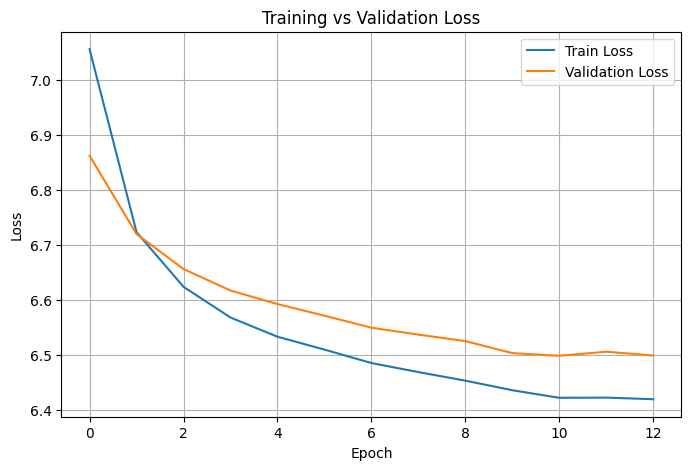

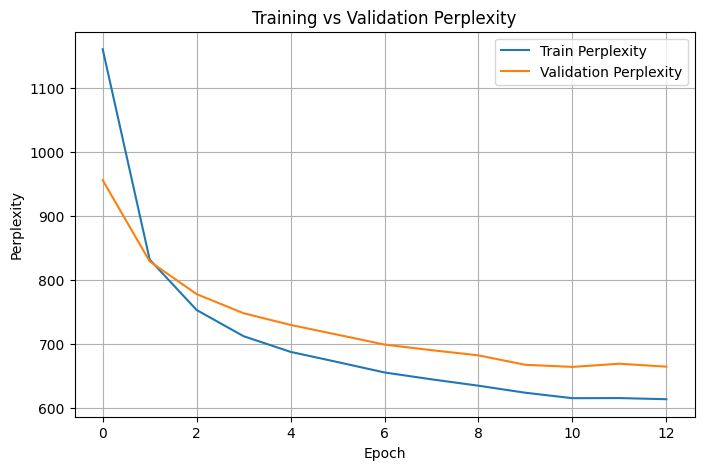

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_perplexities, label='Train Perplexity')
plt.plot(val_perplexities, label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training vs Validation Perplexity')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))



<All keys matched successfully>

In [ ]:
import math

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            logits = model(x_batch)  # Shape: [batch_size, vocab_size]
            loss = criterion(logits, y_batch)
            total_loss += loss.item() * y_batch.size(0)  # weighted sum of losses

            # Accuracy
            predicted = torch.argmax(logits, dim=1)
            correct = (predicted == y_batch).sum().item()
            total_correct += correct
            total_tokens += y_batch.size(0)

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    accuracy = total_correct / total_tokens

    return avg_loss, perplexity, accuracy


val_loss, val_ppl, val_acc = evaluate_model(model, val_loader, criterion, device)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Perplexity: {val_ppl:.2f}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

test_loss, test_ppl, test_acc = evaluate_model(model, test_loader, criterion, device)

print(f"\n Final Test Performance:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Perplexity: {test_ppl:.2f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")



Validation Loss: 6.4990
Validation Perplexity: 664.47
Validation Accuracy: 16.42%

 Final Test Performance:
Test Loss: 6.6587
Test Perplexity: 779.57
Test Accuracy: 15.65%


In [ ]:
def generate_text(model, start_text, word2idx, idx2word, num_words=10, temperature=3.0):          # increasing the temperature to see how it affects the result
    model.eval()
    words = start_text.strip().split()
    input_seq = torch.tensor([word2idx.get(w, 0) for w in words[-sequence_length:]], dtype=torch.long).unsqueeze(0).to(device)

    generated = words.copy()
    hidden = None

    for _ in range(num_words):
        with torch.no_grad():
            output, hidden = model.lstm(model.embedding(input_seq), hidden)
            logits = model.fc(output[:, -1, :]) / temperature
            probs = torch.softmax(logits, dim=-1)
            next_word_idx = torch.multinomial(probs, num_samples=1).item()

            next_word = idx2word.get(next_word_idx, "<unk>")
            generated.append(next_word)

            input_seq = torch.cat([input_seq[:, 1:], torch.tensor([[next_word_idx]], device=device)], dim=1)

    return ' '.join(generated)


print(generate_text(model, "the king of", word2idx, idx2word))
print(generate_text(model, "what we love is", word2idx, idx2word))
print(generate_text(model, "at night the sky is", word2idx, idx2word))
print(generate_text(model, "The definition of", word2idx, idx2word))

the king of richards doctrine difficulties electrolysis origins mystery fires motions painting persists
what we love is london edu newer interesting hanyu danish trust partnership jpeg mechanics
at night the sky is ribbon books basic decoding fate caspian rainy beverages precipitation fusion
The definition of traditional eyes rather thrust misleading oslo speaker astronomical advice bead


The results shows consistent improvement in both training and validation performance across 13 epochs before early stopping which means effective learning and minimal overfitting. The final test results, test loss of 6.6587, perplexity of 779.57, and accuracy of 15.65%, shows the model generalizes reasonably well, although there's still room for optimization (low accuracy). Text samples generated by the model appear grammatically coherent though they lack semantic meaning, which is expected from a small LSTM trained on limited epochs.

I want to try text generator with more conservative approach now.

In [ ]:
import math

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 40
patience = 2  # Stop if val loss doesn't improve after 2 epochs
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []

best_model_state = None  # for saving best model

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_perplexity = math.exp(avg_train_loss)
    train_losses.append(avg_train_loss)
    train_perplexities.append(train_perplexity)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            logits = model(x_val)
            loss = criterion(logits, y_val)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_perplexity = math.exp(avg_val_loss)
    val_losses.append(avg_val_loss)
    val_perplexities.append(val_perplexity)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train PPL: {train_perplexity:.2f} | Val PPL: {val_perplexity:.2f}")

    # Step scheduler
    # scheduler.step()

    # Early Stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save best model
        torch.save(best_model_state, 'best_model.pth')  # Optional
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= patience:
        print("Early stopping triggered.")
        break

Epoch 1/40 | Train Loss: 7.1811 | Val Loss: 7.0523 | Train PPL: 1314.35 | Val PPL: 1155.55


unfortunately I was not able to train the model for this last purpose due to lack of time and exceeding the GPU limit on Kaggle. I will try it later.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_perplexities, label='Train Perplexity')
plt.plot(val_perplexities, label='Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training vs Validation Perplexity')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import math

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            logits = model(x_batch)  # Shape: [batch_size, vocab_size]
            loss = criterion(logits, y_batch)
            total_loss += loss.item() * y_batch.size(0)  # weighted sum of losses

            # Accuracy
            predicted = torch.argmax(logits, dim=1)
            correct = (predicted == y_batch).sum().item()
            total_correct += correct
            total_tokens += y_batch.size(0)

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    accuracy = total_correct / total_tokens

    return avg_loss, perplexity, accuracy


val_loss, val_ppl, val_acc = evaluate_model(model, val_loader, criterion, device)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Perplexity: {val_ppl:.2f}")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

test_loss, test_ppl, test_acc = evaluate_model(model, test_loader, criterion, device)

print(f"\n Final Test Performance:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Perplexity: {test_ppl:.2f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# trying more deterministic and less diverse generator

temperature=1  >> 0.5

torch.multinomial()  >> torch.argmax()

In [ ]:
def generate_text(model, start_text, word2idx, idx2word, num_words=10, temperature=0.5):
    model.eval()
    words = start_text.strip().split()
    input_seq = torch.tensor([word2idx.get(w, 0) for w in words[-sequence_length:]], dtype=torch.long).unsqueeze(0).to(device)

    generated = words.copy()
    hidden = None

    for _ in range(num_words):
        with torch.no_grad():
            output, hidden = model.lstm(model.embedding(input_seq), hidden)
            logits = model.fc(output[:, -1, :]) / temperature
            probs = torch.softmax(logits, dim=-1)
            next_word_idx = torch.argmax(probs, dim=-1).item()  # argmax: always picks the word with the highest probability


            next_word = idx2word.get(next_word_idx, "<unk>")
            generated.append(next_word)

            input_seq = torch.cat([input_seq[:, 1:], torch.tensor([[next_word_idx]], device=device)], dim=1)

    return ' '.join(generated)


print(generate_text(model, "the king of", word2idx, idx2word))
print(generate_text(model, "what we love is", word2idx, idx2word))
print(generate_text(model, "at night the sky is", word2idx, idx2word))
print(generate_text(model, "The definition of", word2idx, idx2word))

### Questions
Answer the following questions in detail.

1- What is a Recurrent Neural Network (RNN)? Describe its key components and how they differ from those in a feedforward neural network.

recurrent neural networks (RNNs) are designed for processing sequential data, such as text, speech, and time series,[1] where the order of elements is important. Unlike feedforward neural networks, which process inputs independently, RNNs utilize recurrent connections, where the output of a neuron at one time step is fed back as input to the network at the next time step. This enables RNNs to capture temporal dependencies and patterns within sequences.

2- Explain the purpose of the recurrent connection in an RNN. How does it enable the network to handle sequential data?

   The fundamental building block of RNN is the recurrent unit, which maintains a hidden state, a form of memory that is updated at each time step based on the current input and the previous hidden state. This feedback mechanism allows the network to learn from past inputs and incorporate that knowledge into its current processing.

3-  What are vanishing and exploding gradients, and how do they affect the training of RNNs?

The vanishing gradient problem happens when training deep neural networks. In backpropagation, we update weights using gradients (how much the loss changes with each weight). But in very deep networks, the gradients for earlier layers become very small because they go through many steps of multiplication. This makes it hard for those early layers to learn, which can slow down or even stop the training.

The issue of exploding gradients arises when, during backpropagation, the derivatives or slopes of the neural network's layers grow progressively larger as we move backward. This is essentially the opposite of the vanishing gradient problem.

The root cause of this problem lies in the weights of the network. High weight values lead to correspondingly high derivatives, causing significant deviations in new weight values from the previous ones. As a result, the gradient fails to converge and can lead to the network oscillating around local minima, making it challenging to reach the global minimum point.

4- Describe the Long Short-Term Memory (LSTM) network and its key components. How does it address the issues of vanishing and exploding gradients?

Long Short-Term Memory (LSTM) is an enhanced version of the Recurrent Neural Network (RNN) which can capture long-term dependencies in sequential data. Unlike traditional RNNs which use a single hidden state passed through time LSTMs introduce a memory cell that holds information over extended periods addressing the challenge of learning long-term dependencies.

LSTM Architecture
LSTM architectures involves the memory cell which is controlled by three gates:

Input gate: Controls what information is added to the memory cell.
Forget gate: Determines what information is removed from the memory cell.
Output gate: Controls what information is output from the memory cell.

LSTM addresses vanishing and exploding gradients by maintaining a cell state with additive updates, which preserves gradient flow and using gates to control information flow, preventing unnecessary shrinkage or amplification of gradients.

5- What is the purpose of the GRU (Gated Recurrent Unit) in RNNs? Compare it with LSTM.

Gated Recurrent Unit (GRU) where introduced which uses LSTM architecture by merging its gating mechanisms offering a more efficient solution for many sequential tasks without sacrificing performance. GRUs aim to simplify the LSTM architecture by merging some of its components and focusing on just two main gates: the update gate and the reset gate. Update Gate, This gate decides how much information from previous hidden state should be retained for the next time step. Reset Gate, This gate determines how much of the past hidden state should be forgotten.

GRUs are more computationally efficient because they combine the forget and input gates into a single update gate. GRUs do not maintain an internal cell state as LSTMs do, instead they store information directly in the hidden state making them simpler and faster. It performs similarly in many tasks with less complexity but LSTM performs often better in tasks requiring long-term memory.

6- Explain the role of the hidden state in an RNN. How is it updated during the training process?

Hidden State is the memory or the internal state that captures the information from the previous time step. The hidden state at the current time step is computed based on the previous hidden state and the current input.

At each time step t, the RNN takes input from the current element x_t and the hidden state from the previous time step h_(t-1), combines them using weights and an activation function and outputs a new hidden state h_t, which will be used in the next step.



7- What are some common evaluation metrics used to assess the performance of an RNN on a sequential task, such as language modeling or time series forecasting?

there are different metrics for different tasks. for example:

For Language Modeling / Text Generation >> 1. Perplexiy: Measures how well a model predicts a sample; lower is better. 2. Cross-Entropy Loss: Measures the difference between the predicted probability distribution and the true distribution.

For Time Series Forecasting >> 1. Mean Squared Error (MSE) 2. Root Mean Squared Error (RMSE) 3. Mean Absolute Error (MAE)

For Classification like sentiment analysis when we have labels: 1. Accuracy 2. Precision, Recall, F1-Score 3. AUC-ROC







8- How does data preprocessing impact the performance of RNNs? Provide examples of preprocessing steps for text and time series data.

Cleaning and preprocessing data helps the model to capture meaningful relationships rather than noise. this step is very important for RNN as it is very sensitive to any differenece in scale and format of the data, as well as temporal/structural order. for example:

*** For Text Data Preprocessing Steps includes:

Tokenization: Splitting text into words, subwords, or characters.

Lowercasing: Reduces vocabulary size.

Stop-word Removal: Removes frequently used words that might not carry useful meaning (optional for some tasks).

Stemming/Lemmatization: Reduces words to their root forms (optional for some tasks).

Padding/Truncating: Ensures sequences are of uniform length.

Encoding: Convert words into numbers using one-hot encoding, word embeddings (vectorization), or token IDs.

Noise Filtering: Remove non-alphanumeric characters.  

*** For Time Series Data Preprocessing Steps includes:

Handling Missing Data: Impute with interpolation, forward-fill, or model-based methods.

Normalization/Standardization: Scale data to avoid bias from larger numerical values.

Detrending/Deseasonalizing: Helps isolate meaningful patterns by removing cyclic behavior.

Time Alignment: Ensures events are synchronized correctly across series.

Feature Engineering: Create lag features, rolling statistics, or extract timestamp components (e.g., hour, day).

Windowing: Segment data into sliding or fixed windows to fit into RNN format.

Outlier Detection: Identifies and handles anomalies that could skew predictions.

9- What is sequence-to-sequence learning in the context of RNNs, and what are its applications?

Sequence-to-sequence (Seq2Seq) models are a type of deep learning models designed to transform input sequences into output sequences. They're widely used in tasks like machine translation, natural language generation, text summarization, and conversational AI. Seq2Seq models naturally handle variable-length input and output sequences since the encoder and decoder can work with sequences of arbitrary length. Seq2Seq models can learn complex input-output relationships, making them invaluable tools in areas like speech recognition, music generation, and even image captioning.



10- How can RNNs be used for anomaly detection in time series data? Describe the general approach.

First, the model learns what normal behavior looks like by training on historical data. Once trained, the RNN either predicts future values or tries to recreate the input sequence. If the difference between the actual and predicted data is large, it might indicate something unusual. By setting a specific error threshold, we can decide whether a new data point is likely an anomaly.